# Imports

In [ ]:
from __future__ import print_function
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from PIL import Image
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from torchvision import datasets,transforms
import torch.nn.functional as F
import cv2
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from google.colab import files
files.upload()

!pip install -q kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d yash612/covidnet-mini-and-gan-enerated-chest-xray

Saving kaggle.json to kaggle.json
100% 1.50G/1.51G [00:09<00:00, 241MB/s]
100% 1.51G/1.51G [00:09<00:00, 178MB/s]


In [ ]:
!unzip covidnet-mini-and-gan-enerated-chest-xray.zip -d data

Streaming output truncated to the last 5000 lines.
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray204.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray205.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray206.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray207.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray208.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray209.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray21.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray210.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray211.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray212.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray213.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray214.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORM

# First Pass: Training on All Images

In [ ]:
import os
imagefiles=[]
labels=[]
for folder in os.listdir('./data/chest_xray/chest_xray/train'):
  path=os.path.join('./data/chest_xray/chest_xray/train',folder)
  for images in os.listdir(path):
    imagefiles.append(os.path.join(path,images))
    labels.append(folder)
testimages=[]
testlabel=[]
for folder in os.listdir('./data/chest_xray/chest_xray/test'):
  path=os.path.join('./data/chest_xray/chest_xray/test',folder)
  for images in os.listdir(path):
    testimages.append(os.path.join(path,images))
    testlabel.append(folder)
enc={}
for i,label in enumerate(os.listdir('./data/chest_xray/chest_xray/train')):
  enc[label]=i

# VAE: Load Data, prepare methods

In [ ]:
class Data(Dataset):
  def __init__(self,imagefiles,labels,testimages,testlabel,mode,enc=None,transform=None):
    self.imagefiles=imagefiles
    self.labels=labels
    self.testimages=testimages
    self.testlabel=testlabel
    self.mode=mode
    self.transform=transform
    self.enc=enc
  def __getitem__(self,idx):
    if self.mode=='train':
      image=Image.open(self.imagefiles[idx])
      image=np.asarray(image) 
      image=torch.from_numpy(image)
      label=self.labels[idx]
      if self.transform:
        image=self.transform(image)
      return image,enc[label]
    if self.mode=='test':
      image=Image.open(self.testimages[idx])
      image=np.asarray(image)
      image=torch.from_numpy(image)
      label=self.testlabel[idx]
      if self.transform:
        image=self.transform(image)
      return image,enc[label]
  def __len__(self):
    if self.mode=='train':
      return len(self.imagefiles)
    if self.mode=='test':
      return len(self.testimages)

In [ ]:
transform=transforms.Compose([
                              transforms.ToPILImage(),
                              transforms.Grayscale(num_output_channels=1),
                              transforms.Resize((100,100)),
                              transforms.RandomHorizontalFlip(p=0.5),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5,),(0.5,))
                              ])
train_dataset=datasets.ImageFolder('./data/chest_xray/chest_xray/train',transform=transform)
val_dataset=datasets.ImageFolder('./data/chest_xray/chest_xray/val',transform=transform)
test_dataset=datasets.ImageFolder('./data/chest_xray/chest_xray/test',transform=transform)


In [ ]:
mode1='train'
trainset=Data(imagefiles,labels,testimages,testlabel,mode1,enc,transform)
trainLoader=torch.utils.data.DataLoader(trainset,batch_size=5,shuffle=True)

In [ ]:
mode2='test'
testset=Data(imagefiles,labels,testimages,testlabel,mode2,enc,transform)
testLoader=torch.utils.data.DataLoader(testset,batch_size=5,shuffle=False)

# VAE Model

In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        #3*128*128=49152
        self.fc1 = nn.Linear(10000, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 10000)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 10000))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Parameters & Run Model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VAE()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [ ]:
best_test_loss = float('inf')
best_loss_checker=0
for epochs in range(0,31):
  train_loss=0
  test_loss = 0
  for img,lab in trainLoader:
    img=img.view(-1,10000)
    img=F.softmax(img)
    optimizer.zero_grad()
    img_sample, mu1, var = model(img)

    #Upon TA sugesstion, use CXEntropy
    cx_loss = F.binary_cross_entropy(img_sample, img, size_average=False)

    #Metric used: KL Loss (chosen on literature review)
    kl_loss = 0.5 * torch.sum(torch.exp(var) + mu1**2 - 1.0 - var)

    loss = cx_loss + kl_loss
    loss.backward()
    train_loss += loss.item()
    optimizer.step()
  else:
    with torch.no_grad():
      print('Testing')
      for img,lab in testLoader:

        img = img.view(-1, 10000)
        img=F.softmax(img)

        img_sample, mu1, var = model(img)

        cx_loss = F.binary_cross_entropy(img_sample, img, size_average=False)
        kl_loss = 0.5 * torch.sum(torch.exp(var) + mu1**2 - 1.0 - var)

        loss = cx_loss + kl_loss
        test_loss += loss.item()

  train_loss /= len(trainLoader)
  test_loss /= len(testLoader)
  print(f'Epoch: {epochs}, Train Loss: {train_loss:.2f}, Test Loss: {test_loss:.2f}')
  if best_test_loss > test_loss:
    best_test_loss = test_loss
    best_loss_checker = 1
  else:
    best_loss_checker += 1
  if best_loss_checker > 3:
    break

Started accessing trainloader


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


accessing test loader


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 0, Train Loss: 214.04, Test Loss: 54.53
Started accessing trainloader
accessing test loader
Epoch 1, Train Loss: 53.91, Test Loss: 53.38
Started accessing trainloader
accessing test loader
Epoch 2, Train Loss: 53.06, Test Loss: 52.63
Started accessing trainloader
accessing test loader
Epoch 3, Train Loss: 52.32, Test Loss: 51.87
Started accessing trainloader
accessing test loader
Epoch 4, Train Loss: 51.56, Test Loss: 51.26
Started accessing trainloader
accessing test loader
Epoch 5, Train Loss: 51.12, Test Loss: 50.94
Started accessing trainloader
accessing test loader
Epoch 6, Train Loss: 50.92, Test Loss: 50.86
Started accessing trainloader
accessing test loader
Epoch 7, Train Loss: 50.88, Test Loss: 50.82
Started accessing trainloader
accessing test loader
Epoch 8, Train Loss: 50.89, Test Loss: 50.90
Started accessing trainloader
accessing test loader
Epoch 9, Train Loss: 50.94, Test Loss: 50.91
Started accessing trainloader
accessing test loader
Epoch 10, Train Loss: 51.04, 

# Save to drive

In [ ]:
import os
imagefiles=[]
labels=[]

for folder in os.listdir('./data/chest_xray/chest_xray/train'):
  print("NOT saving this: ", folder)
  if folder == "CORONA":
    print("Saving this: ", folder)
    path=os.path.join('./data/chest_xray/chest_xray/train',folder)
    for images in os.listdir(path):
      imagefiles.append(os.path.join(path,images))
      labels.append(folder)

testimages=[]
testlabel=[]
for folder in os.listdir('./data/chest_xray/chest_xray/test'):
  print("NOT saving this: ", folder)
  if folder == "CORONA":
    print("Saving this: ", folder)
    path=os.path.join('./data/chest_xray/chest_xray/test',folder)
    for images in os.listdir(path):
      testimages.append(os.path.join(path,images))
      testlabel.append(folder)

enc={}
for i,label in enumerate(os.listdir('./data/chest_xray/chest_xray/train')):
  print("NOT saving this: ", label)
  if label == "CORONA":
      print("Saving this: ", label)
      enc[label]=i

In [ ]:
mode1='train'
trainset=Data(imagefiles,labels,testimages,testlabel,mode1,enc,transform)
trainLoader=torch.utils.data.DataLoader(trainset,batch_size=5,shuffle=True)


In [ ]:
mode2='test'
testset=Data(imagefiles,labels,testimages,testlabel,mode2,enc,transform)
testLoader=torch.utils.data.DataLoader(testset,batch_size=5,shuffle=False)

In [ ]:
best_test_loss = float('inf')
best_loss_checker=0
for epochs in range(0,31):
  train_loss=0
  test_loss = 0
  print('Training')
  for img,lab in trainLoader:
    img=img.view(-1,10000)
    img=F.softmax(img)
    optimizer.zero_grad()
    img_sample, mu1, var = model(img)
    cx_loss = F.binary_cross_entropy(img_sample, img, size_average=False)
    kl_loss = 0.5 * torch.sum(torch.exp(var) + mu1**2 - 1.0 - var)
    loss = cx_loss + kl_loss
    loss.backward()
    train_loss += loss.item()
    optimizer.step()
  else:
    with torch.no_grad():
      print('Testing')
      for img,lab in testLoader:
        img = img.view(-1, 10000)
        img=F.softmax(img)
        img_sample, mu1, var = model(img)
        cx_loss = F.binary_cross_entropy(img_sample, img, size_average=False)
        kl_loss = 0.5 * torch.sum(torch.exp(var) + mu1**2 - 1.0 - var)
        loss = cx_loss + kl_loss
        test_loss += loss.item()

  train_loss /= len(trainLoader)
  test_loss /= len(testLoader)
  print(f'Epoch: {epochs}, Train Loss: {train_loss:.2f}, Test Loss: {test_loss:.2f}')

  #Stops if not improving
  if best_test_loss > test_loss:
    best_test_loss = test_loss
    best_loss_checker = 1
  else:
    best_loss_checker += 1
  if best_loss_checker > 3:
    break

Started accessing trainloader


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


accessing test loader


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 0, Train Loss: 51.02, Test Loss: 46.41
Started accessing trainloader
accessing test loader
Epoch 1, Train Loss: 51.02, Test Loss: 46.46
Started accessing trainloader
accessing test loader
Epoch 2, Train Loss: 51.01, Test Loss: 46.42
Started accessing trainloader
accessing test loader
Epoch 3, Train Loss: 51.02, Test Loss: 46.47


In [ ]:
image_dir = '/content/gdrive/My Drive/generated_COVID'

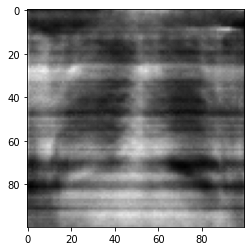

In [ ]:
for img_num in range(1,501):
    z = torch.randn(1, 20)
    
    reconstructed_img = model.decode(z)
    img = reconstructed_img.view(100, 100).data

    plt.imshow(img,cmap='gray')
    name_img = img_num + 110
    plt.savefig("{}/VAE_{}.jpg".format(image_dir, name_img))

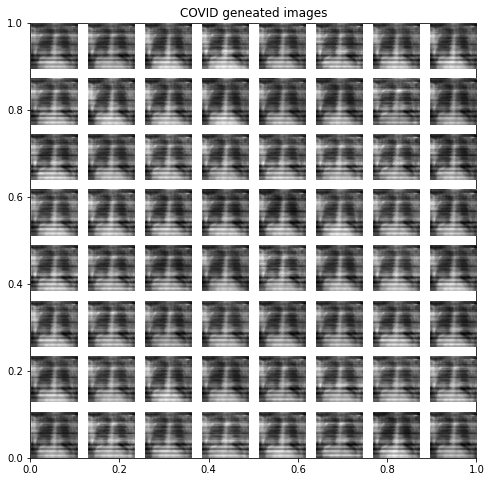

In [ ]:
w=10
h=10
fig=plt.figure(figsize=(8, 8))
plt.title("COVID geneated images")
columns = 8
rows = 8
for i in range(1, columns*rows +1):
    # img = np.random.randint(10, size=(h,w))
    z = torch.randn(1, 20)
    reconstructed_img = model.decode(z)
    img = reconstructed_img.view(100, 100).data
    fig.add_subplot(rows, columns, i)
    plt.imshow(img,cmap='gray')
    plt.axis("off")

plt.show()